In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score
import glob
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # The dataset is saved inside my google drive 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extracting data in DataFrame format
main_path = '/content/drive/MyDrive/קורס למידה עמוקה/DATA/chest_xray'


train_path = os.path.join(main_path,'train')
test_path=os.path.join(main_path,'test')

train_normal = glob.glob(train_path+'/NORMAL/*.jpeg')
train_pneumonia = glob.glob(train_path+'/PNEUMONIA/*.jpeg')

test_normal = glob.glob(test_path+'/NORMAL/*.jpeg')
test_pneumonia = glob.glob(test_path+'/PNEUMONIA/*.jpeg')

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [ ]:
# Splitting train dataframe to train(90%) and validation(10%)
train_df, val_df = train_test_split(df_train, test_size = 0.1, random_state = 42, stratify = df_train['class'])

In [ ]:
print(f'Number of pictures in Validation dataset: {len(val_df)}')
print(f'Number of pictures in Train dataset: {len(train_df)}')

Number of pictures in Validation dataset: 522
Number of pictures in Train dataset: 4694


In [ ]:
# Preproccesing data
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             color_mode = 'rgb',
                                             batch_size = batch_size,
                                             shuffle=True,
                                             seed = 42)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (224, 224),
                                        class_mode = 'binary',
                                        color_mode = 'rgb',
                                        batch_size = batch_size,
                                        shuffle=True,
                                        seed = 42)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (224, 224),
                                        class_mode = 'binary',
                                        color_mode = 'rgb',
                                        batch_size = 1,
                                        shuffle = False)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print(ds_train.image_shape)

Found 4694 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
(224, 224, 3)


VGG16

In [ ]:
pre_trained_model = tf.keras.applications.vgg16.VGG16(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in pre_trained_model.layers:
      if layer.name == 'block3_conv1' or layer.name == 'block3_conv2':
        layer.trainable = True
      else:
        layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
epochs = 50 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

history = model.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val, callbacks=[callback])

Epoch 1/50
74/74 [==============================] - 126s 1s/step - loss: 0.4202 - accuracy: 0.7997 - val_loss: 0.1787 - val_accuracy: 0.9617
Epoch 2/50
74/74 [==============================] - 94s 1s/step - loss: 0.1421 - accuracy: 0.9504 - val_loss: 0.0950 - val_accuracy: 0.9598
Epoch 3/50
74/74 [==============================] - 94s 1s/step - loss: 0.0868 - accuracy: 0.9719 - val_loss: 0.0710 - val_accuracy: 0.9732
Epoch 4/50
74/74 [==============================] - 88s 1s/step - loss: 0.0677 - accuracy: 0.9778 - val_loss: 0.0593 - val_accuracy: 0.9789
Epoch 5/50
74/74 [==============================] - 92s 1s/step - loss: 0.0577 - accuracy: 0.9789 - val_loss: 0.0648 - val_accuracy: 0.9693
Epoch 6/50
74/74 [==============================] - 91s 1s/step - loss: 0.0488 - accuracy: 0.9838 - val_loss: 0.0532 - val_accuracy: 0.9770
Epoch 7/50
74/74 [==============================] - 93s 1s/step - loss: 0.0384 - accuracy: 0.9874 - val_loss: 0.0463 - val_accuracy: 0.9828
Epoch 8/50
74/74 [=

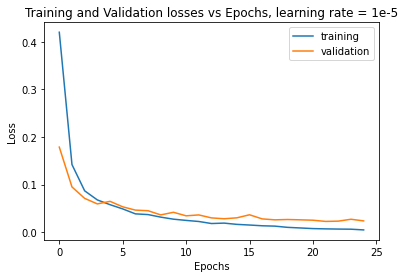

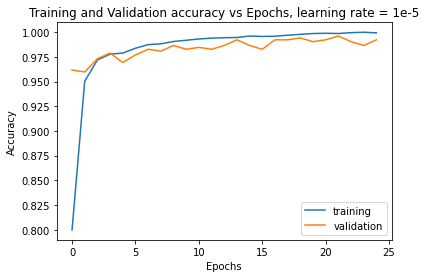

In [ ]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(ds_test)

624/624 [==============================] - 24s 37ms/step - loss: 1.1366 - accuracy: 0.7933


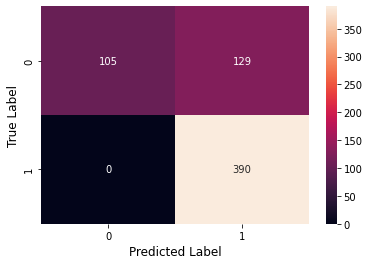

In [ ]:
import seaborn as sns

num_label = {'Normal':0, 'Pneumonia':1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model.predict(ds_test,steps=len(ds_test),verbose=0)
pred_labels = np.where(predictions > 0.5, 1,0)

cm = confusion_matrix(Y_test,pred_labels)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.show()

In [ ]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 1.00
Precision score is: 0.75


Resnet50

In [ ]:
pre_trained_model_Res2 = tf.keras.applications.resnet50.ResNet50(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

pre_trained_model_Res2.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
for layer in pre_trained_model_Res2.layers:
      if layer.name == 'conv3_block3_2_conv' or layer.name == 'conv3_block3_3_conv':
        layer.trainable = True
      else:
        layer.trainable = False

In [ ]:
x = layers.Flatten()(pre_trained_model_Res2.output)
x = layers.Dense(256, activation='relu')(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Compile
modelRes2 = tf.keras.Model(pre_trained_model_Res2.input, outputs)

modelRes2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
epochs = 60 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

modelRes2.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

historyRes2 = modelRes2.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val, callbacks=[callback])

Epoch 1/60
74/74 [==============================] - 98s 1s/step - loss: 0.5232 - accuracy: 0.7527 - val_loss: 0.4083 - val_accuracy: 0.8103
Epoch 2/60
74/74 [==============================] - 88s 1s/step - loss: 0.3748 - accuracy: 0.8170 - val_loss: 0.3364 - val_accuracy: 0.8295
Epoch 3/60
74/74 [==============================] - 87s 1s/step - loss: 0.3398 - accuracy: 0.8434 - val_loss: 0.3026 - val_accuracy: 0.8602
Epoch 4/60
74/74 [==============================] - 86s 1s/step - loss: 0.2885 - accuracy: 0.8752 - val_loss: 0.2783 - val_accuracy: 0.8697
Epoch 5/60
74/74 [==============================] - 86s 1s/step - loss: 0.2689 - accuracy: 0.8830 - val_loss: 0.2583 - val_accuracy: 0.8851
Epoch 6/60
74/74 [==============================] - 87s 1s/step - loss: 0.2480 - accuracy: 0.9014 - val_loss: 0.2620 - val_accuracy: 0.8812
Epoch 7/60
74/74 [==============================] - 87s 1s/step - loss: 0.2263 - accuracy: 0.9058 - val_loss: 0.2212 - val_accuracy: 0.9157
Epoch 8/60
74/74 [==

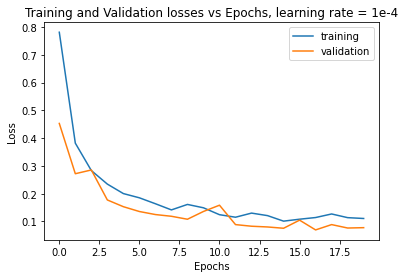

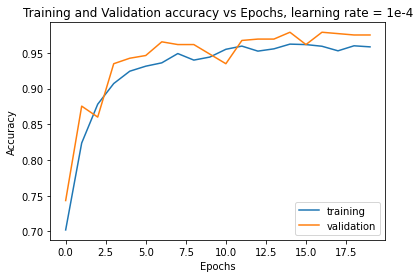

In [ ]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(historyRes2.history['loss'])
plt.plot(historyRes2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-4') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(historyRes2.history['accuracy'])
plt.plot(historyRes2.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-4') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
test_loss, test_accuracy = modelRes2.evaluate(ds_test)

624/624 [==============================] - 118s 188ms/step - loss: 0.5936 - accuracy: 0.7724


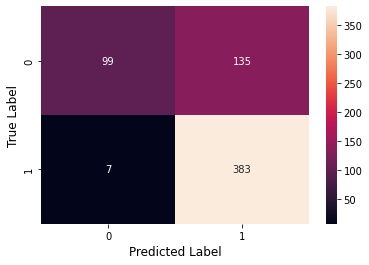

In [ ]:
import seaborn as sns

num_label = {'Normal':0, 'Pneumonia':1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = modelRes2.predict(ds_test,steps=len(ds_test),verbose=0)
pred_labels = np.where(predictions > 0.5, 1,0)

cm = confusion_matrix(Y_test,pred_labels)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.show()

In [ ]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 0.98
Precision score is: 0.74


In [ ]:
tf.keras.backend.clear_session() # Run cell before __.fit command